In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_sample_weight
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from xgboost import XGBClassifier

In [ ]:
def apply_clahe(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    enhanced_lab = cv2.merge((cl, a, b))
    return cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)

def resize_with_padding(image, target_size=(224, 224)):
    h, w = image.shape[:2]
    scale = min(target_size[0] / h, target_size[1] / w)
    new_h, new_w = int(h * scale), int(w * scale)
    resized = cv2.resize(image, (new_w, new_h))
    delta_w = target_size[1] - new_w
    delta_h = target_size[0] - new_h
    top, bottom = delta_h // 2, delta_h - delta_h // 2
    left, right = delta_w // 2, delta_w - delta_w // 2
    return cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

def extract_vgg16_features(image_path, model):
    img = cv2.imread(image_path)
    img = apply_clahe(img)
    img = resize_with_padding(img, (224, 224))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    features = model.predict(img_array)
    return features.flatten()


In [ ]:
def extract_gabor_features(image, ksize=31):
    gabor_features = []
    for theta in np.arange(0, np.pi, np.pi / 4):
        for sigma in (1, 3):
            for lamda in np.pi / np.array([4, 8]):
                kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, 0.5, 0, ktype=cv2.CV_32F)
                filtered = cv2.filter2D(image, cv2.CV_8UC3, kernel)
                gabor_features.append(np.mean(filtered))
                gabor_features.append(np.std(filtered))
    return gabor_features

In [ ]:
def extract_vgg16_features(image_path, model):
    img = cv2.imread(image_path)
    img_clahe = apply_clahe(img)
    resized_img = resize_with_padding(augmented, (224, 224))
    img_array = img_to_array(resized_img) / 255.0
    img_array_exp = np.expand_dims(img_array, axis=0)
    vgg_features = model.predict(img_array_exp, verbose=0).flatten()
    gray = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
    gabor_feats = extract_gabor_features(gray)
    reduced_vgg = vgg_features[:2048]
    return np.concatenate([reduced_vgg, gabor_feats])

In [ ]:
def load_dataset(image_folder, model):
    X, y = [], []
    for class_folder in os.listdir(image_folder):
        class_path = os.path.join(image_folder, class_folder)
        if os.path.isdir(class_path):
            for img_file in os.listdir(class_path):
                img_path = os.path.join(class_path, img_file)
                features = extract_vgg16_features(img_path, model)
                X.append(features)
                y.append(class_folder)
    return np.array(X), np.array(y)

In [ ]:
image_folder = "/content/drive/MyDrive/coral_data"
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg_feature_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.output)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
X, y = load_dataset(image_folder, vgg_feature_extractor)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y_encoded, test_size=0.15, random_state=42, stratify=y_encoded)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=42, stratify=y_train_val)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━

In [ ]:
np.save("/content/drive/MyDrive/X_features.npy", X)
np.save("/content/drive/MyDrive/y_labels.npy", y)

In [ ]:
X = np.load('/content/drive/MyDrive/X_features.npy')
y = np.load('/content/drive/MyDrive/y_labels.npy')

In [ ]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y_encoded, test_size=0.15, random_state=42, stratify=y_encoded)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=42, stratify=y_train_val)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [ ]:
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.05,
    objective='multi:softmax',
    num_class=len(np.unique(y_encoded)),
    eval_metric='mlogloss',
    random_state=42,
    use_label_encoder=False
)

xgb_model.fit(
    X_train, y_train,
    sample_weight=sample_weights,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    #eval_metric="mlogloss",
    verbose=True,
)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:25:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:1.05404	validation_1-mlogloss:1.07039
[1]	validation_0-mlogloss:1.01234	validation_1-mlogloss:1.04189
[2]	validation_0-mlogloss:0.97366	validation_1-mlogloss:1.01716
[3]	validation_0-mlogloss:0.93685	validation_1-mlogloss:0.99359
[4]	validation_0-mlogloss:0.90182	validation_1-mlogloss:0.97315
[5]	validation_0-mlogloss:0.86839	validation_1-mlogloss:0.95324
[6]	validation_0-mlogloss:0.83680	validation_1-mlogloss:0.93452
[7]	validation_0-mlogloss:0.80661	validation_1-mlogloss:0.91456
[8]	validation_0-mlogloss:0.77904	validation_1-mlogloss:0.89645
[9]	validation_0-mlogloss:0.75254	validation_1-mlogloss:0.87926
[10]	validation_0-mlogloss:0.72683	validation_1-mlogloss:0.86516
[11]	validation_0-mlogloss:0.70247	validation_1-mlogloss:0.85026
[12]	validation_0-mlogloss:0.67890	validation_1-mlogloss:0.83550
[13]	validation_0-mlogloss:0.65706	validation_1-mlogloss:0.82027
[14]	validation_0-mlogloss:0.63483	validation_1-mlogloss:0.80634
[15]	validation_0-mlogloss:0.61426	

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_class=3, num_parallel_tree=None, ...)

In [ ]:
y_val_pred = xgb_model.predict(X_val)
y_test_pred = xgb_model.predict(X_test)

print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

print("\nValidation Classification Report:\n", classification_report(y_val, y_val_pred, target_names=label_encoder.classes_))
print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

Validation Accuracy: 0.8266199649737302
Test Accuracy: 0.8241430700447094

Validation Classification Report:
               precision    recall  f1-score   support

    bleached       0.84      0.81      0.83       221
    diseased       0.77      0.85      0.81       121
     healthy       0.84      0.83      0.84       229

    accuracy                           0.83       571
   macro avg       0.82      0.83      0.82       571
weighted avg       0.83      0.83      0.83       571


Test Classification Report:
               precision    recall  f1-score   support

    bleached       0.83      0.78      0.81       259
    diseased       0.78      0.87      0.82       143
     healthy       0.85      0.84      0.84       269

    accuracy                           0.82       671
   macro avg       0.82      0.83      0.82       671
weighted avg       0.83      0.82      0.82       671



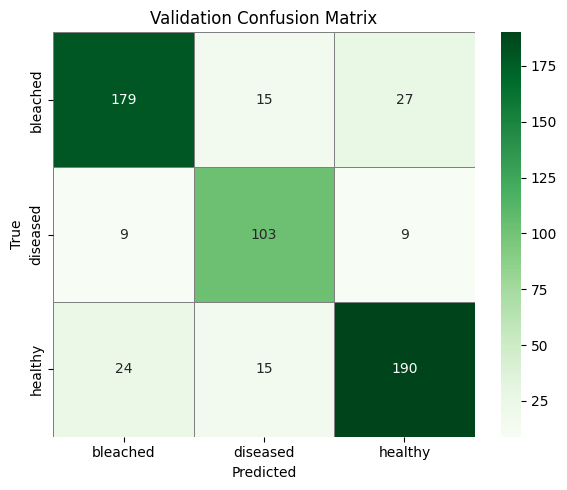

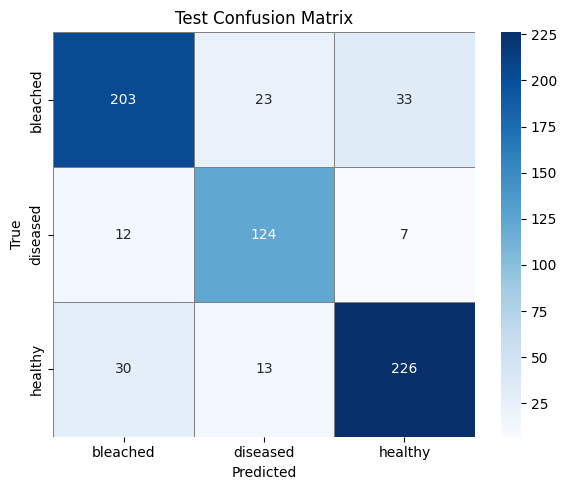

In [ ]:
def plot_confusion_matrix(y_true, y_pred, title, cmap):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap,
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_,
                linewidths=0.5, linecolor='gray')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Use pure greens and blues
plot_confusion_matrix(y_val, y_val_pred, "Validation Confusion Matrix", cmap="Greens")
plot_confusion_matrix(y_test, y_test_pred, "Test Confusion Matrix", cmap="Blues")


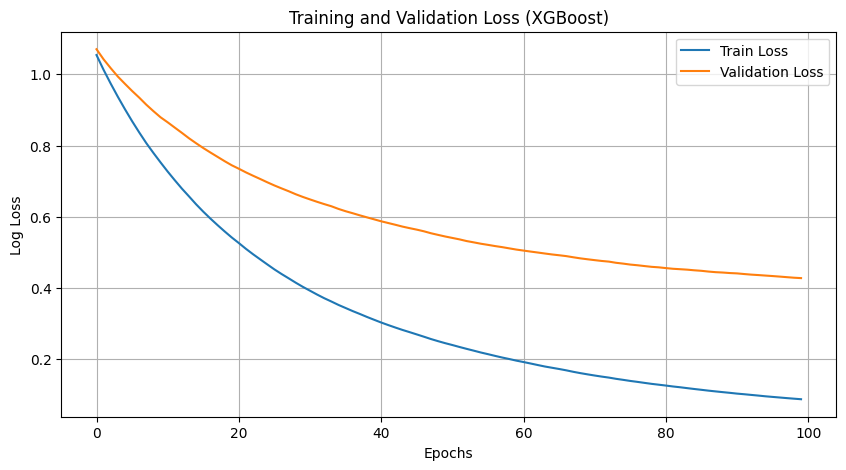

In [ ]:
evals_result = xgb_model.evals_result()
epochs = range(len(evals_result['validation_0']['mlogloss']))

plt.figure(figsize=(10, 5))
plt.plot(epochs, evals_result['validation_0']['mlogloss'], label='Train Loss')
plt.plot(epochs, evals_result['validation_1']['mlogloss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
vgg_feature_extractor.save("/content/drive/MyDrive/vgg16_feature_extractor.h5")

In [ ]:
# Load models
with open("/content/drive/MyDrive/final_xgboost_model.pkl", "rb") as f:
    xgb_model = pickle.load(f)

vgg_feature_extractor = load_model("vgg16_feature_extractor.h5")

with open("/content/drive/MyDrive/final_scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

with open("/content/drive/MyDrive/final_label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)

In [ ]:
def resize_with_padding(image, target_size=(224, 224), pad_color=(255, 255, 255)):

    h, w = image.shape[:2]
    scale = min(target_size[0] / h, target_size[1] / w)
    new_h, new_w = int(h * scale), int(w * scale)
    resized = cv2.resize(image, (new_w, new_h))

    delta_w = target_size[1] - new_w
    delta_h = target_size[0] - new_h
    top, bottom = delta_h // 2, delta_h - delta_h // 2
    left, right = delta_w // 2, delta_w - delta_w // 2

    padded = cv2.copyMakeBorder(resized, top, bottom, left, right,
                                cv2.BORDER_CONSTANT, value=pad_color)
    return padded


def predict_and_display(folder_path):

    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    plt.figure(figsize=(20, 12))

    for i, img_file in enumerate(image_files[:6]):
        img_path = os.path.join(folder_path, img_file)
        image = cv2.imread(img_path)
        original = image.copy()

        image = apply_clahe(image)
        image = resize_with_padding(image)
        img_array = img_to_array(image) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        features = vgg_feature_extractor.predict(img_array).flatten()
        features_scaled = scaler.transform([features])

        pred = xgb_model.predict(features_scaled)
        label = label_encoder.inverse_transform(pred)[0]

        output_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.subplot(2, 3, i + 1)
        plt.imshow(output_img)
        plt.title(f"Prediction: {label}", fontsize=25, color='black')
        plt.axis("off")

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step


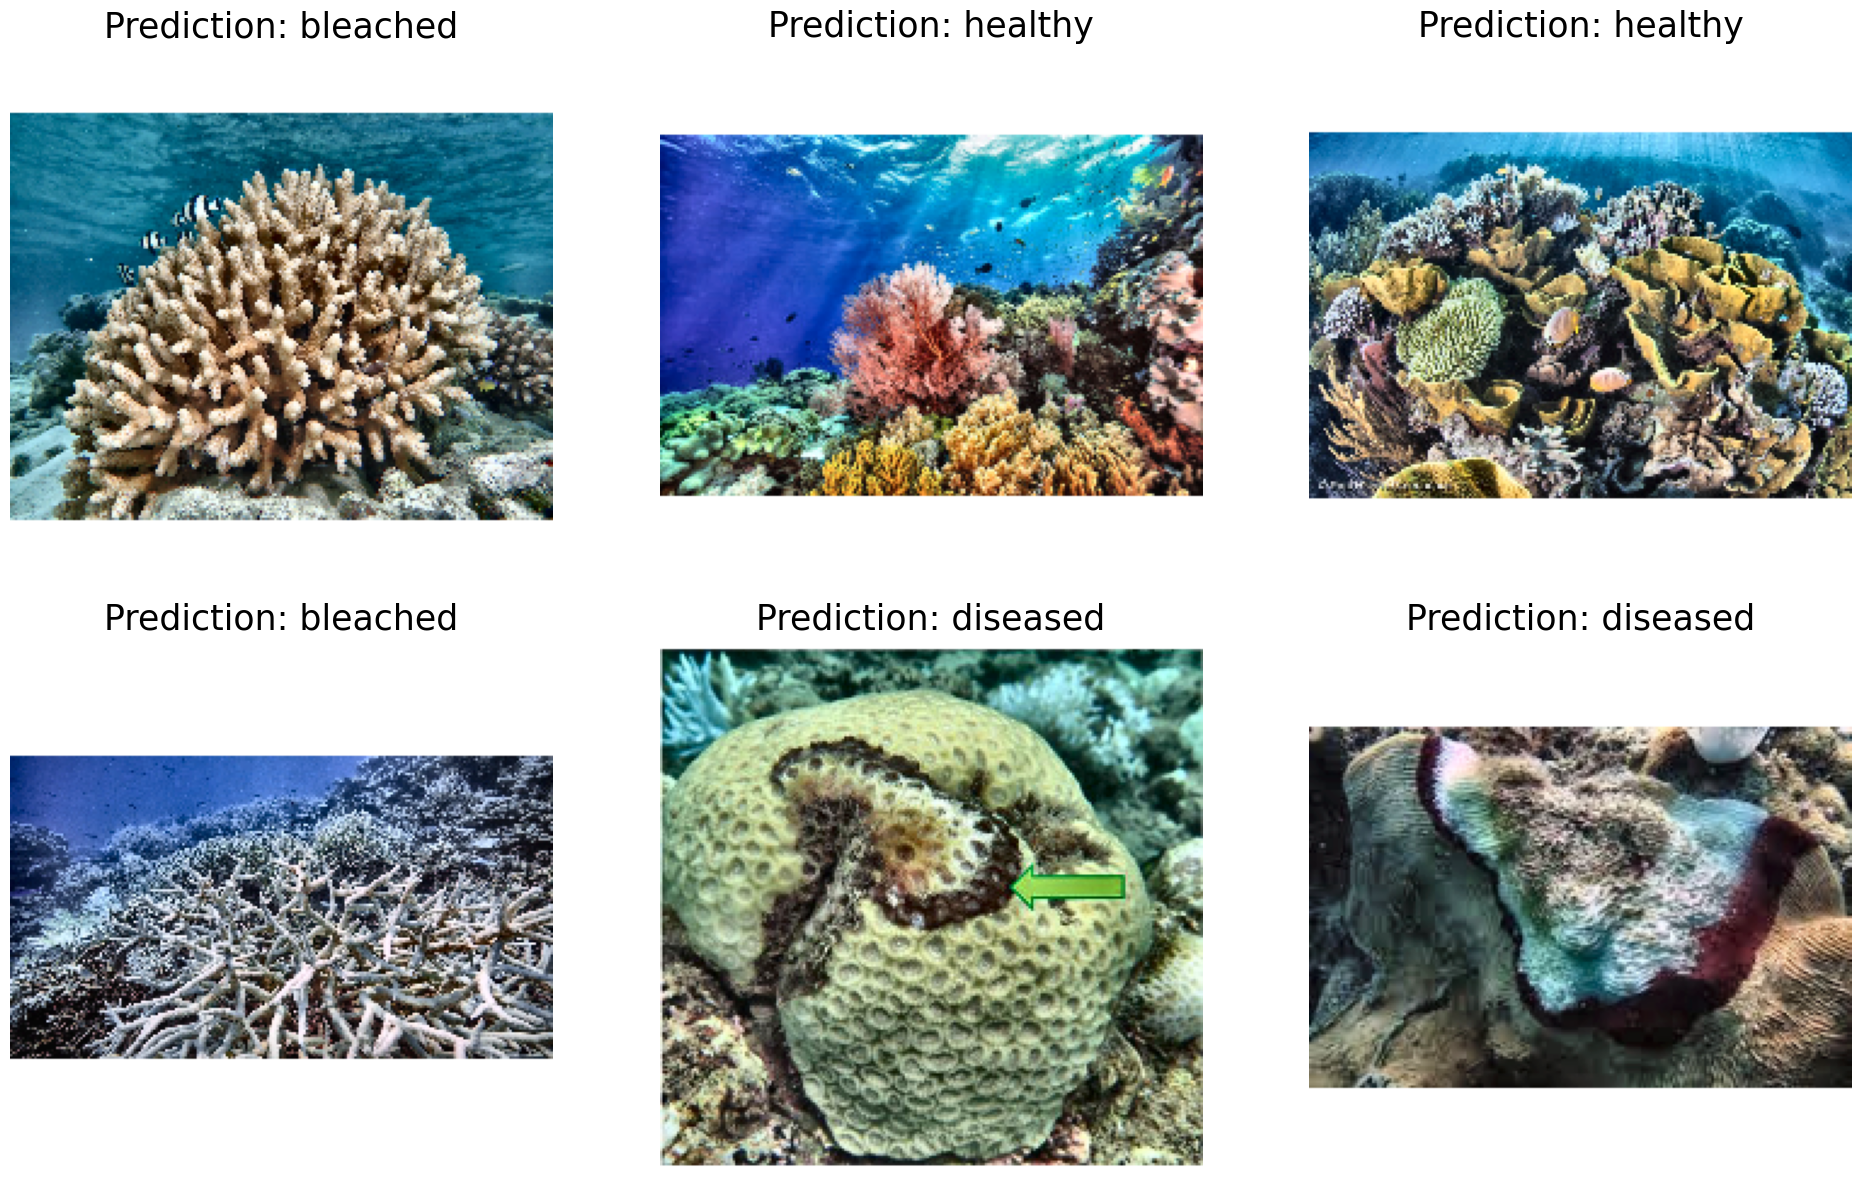

In [ ]:
predict_and_display("/content/drive/MyDrive/test_images")

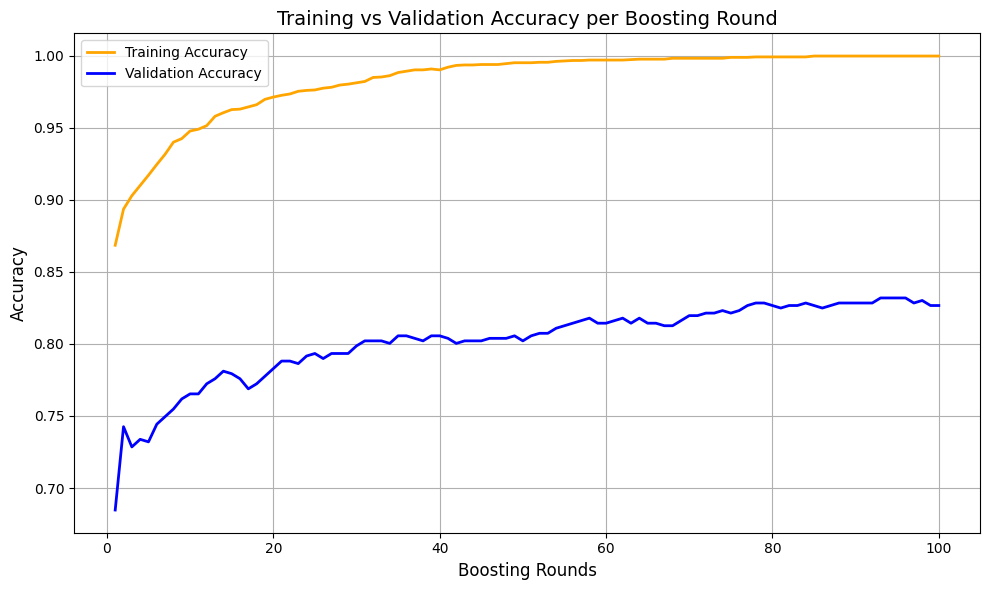

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import xgboost as xgb

results = xgb_model.evals_result()
n_rounds = len(results['validation_0']['mlogloss'])

train_accuracies = []
val_accuracies = []

for i in range(1, n_rounds + 1):
    train_preds = xgb_model.predict(X_train, iteration_range=(0, i))
    val_preds = xgb_model.predict(X_val, iteration_range=(0, i))

    train_accuracies.append(accuracy_score(y_train, train_preds))
    val_accuracies.append(accuracy_score(y_val, val_preds))

plt.figure(figsize=(10, 6))
plt.plot(range(1, n_rounds + 1), train_accuracies, label="Training Accuracy", color='orange', linewidth=2)
plt.plot(range(1, n_rounds + 1), val_accuracies, label="Validation Accuracy", color='blue', linewidth=2)

plt.xlabel("Boosting Rounds", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Training vs Validation Accuracy per Boosting Round", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
